# LangChain实战

本节将针对每种框架，详细介绍1-2个实战案例，手把手带大家学习每种框架的实战应用。

通过本节学习，你将：

- 掌握LangChain实战应用的基本方法

**开始之前**
<div class="alert alert-success">
目前LangChain和Semantic Kernel都处于快速迭代阶段，无论是本教材还是网上的教材，甚至是官方文档，都可能存在参考代码无法运行的情况。建议大家在实践过程中，以简单模块为主，如果几个步骤可以由简单模块组合而成，那么优先使用简单模块的组合，而不是使用复杂模块。
</div>

<div class="alert alert-warning">

**每次运行前，请先安装以下依赖**
</div>


In [1]:
# !pip install -U openai

In [2]:
# !pip install -r requirements.txt

In [3]:
# !pip install -r requirements-new.txt

## 一、LangGraph

### （一）、图论

<div class="alert alert-success">
图论（graph theory）是数学领域中的一个分支，专注于研究图。这里的图是指由节点和边组成的结构，其中节点表示实体，而边则代表这些实体之间的连接或关系。通过这种结构，图论能够建模并分析不同对象间的关系模式，以点表示对象，以点间的连线表示它们之间存在的关联。
</div>

#### 1、图的基本概念

#### 1.1、点和边

图由顶点和边构成，边用于连接两个点
- 顶点：通常用 V(vertex) 表示顶点集合
    - 度(Degree)：所有与该点连接的边数之和
    - 入度(Indegree)：存在于有向图中，所有接入该点的边数之和
    - 出度(Outdegree)：存在于有向图中，所有接出该点的之数之和
- 边：通常用 $E$(edge) 表示边的集合
#### 1.2、有向图和无向图

- $(v, w)$ 表示无向边，即 $v$ 和 $w$ 是互通的
- $<v, w>$ 表示有向边，该边始于 $v$，终于 $w$

#### 1.3、有权图和无权图
- 有权图(Weighted Graph)：每条边具有一定的权重(weight)，通常是一个数字
- 无权图(Unweighted Graph)：每条边均没有权重，也可以理解为权为1

#### 2、图的表示

#### 邻接矩阵和邻接表
邻接矩阵是表示图形中顶点之间相邻关系的矩阵，对于n个顶点的图而言，矩阵是的row和col表示的是1....n的顶点。常用链表的形式表示，使用链表表示时，也可以叫邻接链表。

**无向无权图**：

<img src="images/graph1.png" alt="LangChain Framework" width="80%"><br>

**无向有权图**：

<img src="images/graph2.png" alt="LangChain Framework" width="80%"><br>

**有向有权图**：

<img src="images/graph3.png" alt="LangChain Framework" width="80%"><br>

#### 邻接矩阵和邻接表对比
- 邻接矩阵由于没有相连的边也占有空间，因此存在浪费空间的问题，而邻接链表则比较合理地利用空间
- 邻接链表比较耗时，牺牲很大的时间来查找，因此比较耗时，而邻接矩阵法相比邻接链表法来说，时间复杂度低。

### （二）、LangGraph简介

LangGraph是一个库，用于使用LLM构建有状态的多角色应用程序，用于创建Agent和Multi-Agent的工作流。由LangChain的创建者LangChain Inc构建，但可以在不有LangChain的情况下使用。

<img src="images/langchain_stack_112024.svg" alt="LangChain Framework" width="100%"><br>
--<a>https://python.langchain.com/docs/introduction/</a>

在1.0版本之前的LangChain文档中，LangChain和LangGraph并列作为整个LangChain体系的基础架构，LangChain中提供了一个标准接口来与模型进行交互和其他组件进行交互，比较适用构建直接的链以及检索流；而LangGraph是一个针对复杂代理系统的编排框架（orchestration framework），比起LangChain更加底层、可控。

LangChain的Chain和Agent基本上都是线性的方式运行，尽管使用Agent_executor来运行Agent时可以定义“循环”的动作，但控制能力较弱，难以满足多样化的需求。

LangGraph引入了一种创新的方法，将传统的基于AgentExecutor的黑盒调用机制转换为状态图（StateGraph）形式。在这个框架下，依赖于大型语言模型（LLM）的任务，如检索增强生成（RAG）、代码生成等，通过构建详细的图结构来明确定义任务流程中的各个步骤（节点）和它们之间的关系（边）。此图不仅用于设计和理解复杂的任务逻辑，还能够被编译成实际的应用程序。

在任务执行期间，一个中央状态对象（state）贯穿始终，它随着图中节点间的转换而动态更新。这个状态对象的属性可以根据具体应用的需求自定义，确保了灵活性和适应性。因此，LangGraph提供了一种可视化且结构化的方式来管理和优化基于LLM的任务执行过程。

下面对“循环”这个动作进行解释

<img src="images/RAG.png" alt="LangChain Framework" width="100%"><br>
--<a>https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/#agent-state/</a>

上图中是一个RAG的示意图，在使用langchain构建的RAG中，通常是只有从左到右的过程，很少会有从右到左的反馈。在这个图中Rewrite的过程就是一个“循环”的动作。

当Agent进行检索动作后，会进行一次判断，如果不满足生成的条件，则会返回对Prompt进行重写，并重复这个过程直到Agent认为可以将内容送至大模型处理。

这里引入几个概念：
- StateGraph：代表整个状态图的基础类
- Nodes：节点。将每次处理视作一个节点，即节点通常应为一个可以调用的函数、一个可以运行的chain或者agent
- Edges：边。在节点之间的是边，分又可以分为普通边和条件边：普通边代表上一个节点结束后直接进入下一个节点；条件边则代表上一个节点结束后，要进行一次条件判断，决定跳到某个节点

langchain的链通常是一个无环图，通过这样的状态图定义，将无环图变成了有环图，使其可以完成更复杂的问题，并且更加灵活。

#### LangChain与LangGraph的协同关系

LangChain 1.0和LangGraph 1.0并非竞争关系，而是互补协同的设计。两者在AI应用开发中扮演不同角色：

表LangChain 1.0与LangGraph 1.0适用场景对比

|选择依据|LangChain 1.0|LangGraph 1.0|
|--|--|--|
|核心目标|快速构建标准Agent，缩短开发周期|深度定制复杂工作流，保障生产稳定性|
|适用场景|符合"模型→工具→响应"默认流程的Agent；需要快速上线、验证想法的场景|混合确定性逻辑与Agent逻辑的工作流；长周期业务流程；高敏感、需精细控制的场景|
|开发效率|高（高级抽象，开箱即用）|中（需设计图结构，但灵活性更高）|
|与对方关系|基于LangGraph运行时构建，可无缝切换到LangGraph|可嵌入LangChain生成的Agent，组成复杂工作流|

实际开发中，推荐采用渐进式策略：先用LangChain 1.0快速搭建Agent原型验证需求，再使用LangGraph 1.0扩展复杂逻辑，两者可以无缝结合，无需重构代码

#### 1、创建简单的聊天机器人

In [4]:
# Set env var OPENAI_API_KEY or load from a .env file:
import dotenv
dotenv.load_dotenv('../.env')

True

首先，创建一个状态图（stateGraph），这也可以理解成一个“状态机器”，后续可以添加节点来代表大模型、函数，也可以添加边来连接这些模型和函数。

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

把大模型定义成节点，并添加进状态图

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

定义一个“开始边”，也可以理解为“开始”

In [7]:
graph_builder.add_edge(START, "chatbot")

定义一个“结束边”，也可以理解为“关机”

In [8]:
graph_builder.add_edge("chatbot", END)

至此就完成了一个最简单的Langgraph，我们编译一下

In [9]:
graph = graph_builder.compile()

还可以直接打印出图来

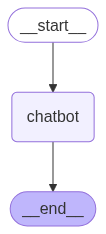

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

下面就可以开始运行这个聊天机器人了，另外定义了一些结束的输入

In [11]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [12]:
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]},config):#使用memory时要把config传给langGraph
    # for event in graph.stream({"messages": [("user", user_input)]}):

        # print(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  quit


Goodbye!


In [13]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=())

#### 2、在聊天机器人基础上添加工具

In [14]:
# !pip install tavily-python

定义工具

In [15]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
# os.environ['TAVILY_API_KEY'] = 'tvly-************'
os.environ['TAVILY_API_KEY'] = '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'
#这个需要到网站上注册一下，每个账户有一定的免费额度，https://app.tavily.com/home
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("视频生成模型可以通过什么样的策略增强生成的人物一致性")

[{'url': 'https://blog.csdn.net/QbitAI/article/details/145957735',
  'content': 'Phantom在主体一致性保持方面取得了突破性进展，不仅支持多主体，还能同时保持主体的完整性。 无论是人物、物品、服装、动物，还是充满奇幻色彩的虚拟角色，'},
 {'url': 'https://www.tsinghua.edu.cn/info/1182/113831.htm',
  'content': 'æ¸\x85å\x8d\x8eä¸»é¡µ\n-\næ¸\x85å\x8d\x8eæ\x96°é\x97»\n-\nåª\x92ä½\x93æ¸\x85å\x8d\x8e\n-\næ\xad£æ\x96\x87\n\nå\x90\x8cä¸\x80ä¸ªå½¢è±¡å\x8f¯å\x87ºç\x8e°å\x9c¨ä¸\x8då\x90\x8cå\x9cºæ\x99¯ä¸\xadï¼\x81 è§\x86é¢\x91å¤§æ¨¡å\x9e\x8bViduè¿\x8eé\x87\x8dç£\x85æ\x9b´æ\x96°\n\næ\x9d¥æº\x90ï¼\x9aæ\x96°äº¬æ\x8a¥ç½\x91 9-11 ç½\x97äº¦ä¸¹\n\n9æ\x9c\x8811æ\x97¥ï¼\x8cç\x94±ç\x94\x9fæ\x95°ç§\x91æ\x8a\x80å\x92\x8cæ¸\x85å\x8d\x8eå¤§å\xad¦è\x81\x94å\x90\x88ç \x94å\x8f\x91ç\x9a\x84è\x87ªç \x94å\x8e\x9få\x88\x9bè§\x86é¢\x91å¤§æ¨¡å\x9e\x8bViduè¿\x8eæ\x9d¥é\x87\x8då¤§æ\x9b´æ\x96°â\x80\x9cä¸»ä½\x93å\x8f\x82ç\x85§â\x80\x9dï¼\x88Subject Consistencyï¼\x89å\x8a\x9fè\x83½ï¼\x8cè¯¥å\x8a\x9fè\x83½è\x83½å¤\x9få®\x9eç\x8e°å¯¹ä»»æ\x84\x8fä¸»ä½\x93ç\x9a\x84ä¸\x80è\x87´æ\x80§ç\x94\x9fæ\x88\x90

同样，先构建一个状态图，并把大模型作为节点添加进图

In [16]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-3.5-turbo")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

构建调用工具的函数，将其作为节点添加进状态图，这里使用的是原始的方式

In [17]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

以下是使用Langgraph的方式来构建调用工具的函数

In [18]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

同样可以把图画出来，此时我们可以看到，多了一个工具节点，并且与大模型之间是一个循环工作的交互方式

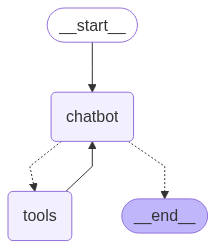

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

来用一下这个新的Agent

In [20]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  quit


Goodbye!


此外，还可以进一步添加内存，也可以加入人的控制，使整个Agent的功能更加强大、灵活。

## 二、用自然语言与数据库交互

自然语言转为结构化查询语句一直是一个热门的研究方向，下面用这个例子来介绍一下如何将大模型与数据库进行结合，以开发一个可能用对话的形式操控数据库的系统。

可能需要安装以下依赖，这里我们使用FAISS库来进行向量化及存储，也可使用其他工具，安装库时，cpu和gpu版本装一个即可

### 创建一个数据库

这里选用SQLite数据库，并使用经典的Chinook数据来进行演示。这个数据库包括了一些艺术家、唱片、媒体、发票以及客户的信息。注意：创建数据库相关操作需在终端进行。

1）安装SQLite<br>
>sudo apt install sqlite

2）从<a ref="https://github.com/lerocha/chinook-database/tree/master/ChinookDatabase/DataSources">这里</a>下载Chinook_Sqlite.sql文件并放到工作目录下，而后在工作目录下运行以下命令

3）创建Chinook_Sqlite.db数据库<br>
>sqlite3 Chinook_Sqlite.db

4）加载数据进数据库（这个过程可能会比较慢）<br>
>.read Chinook_Sqlite.sql

5）查看数据<br>
>SELECT * FROM Artist LIMIT 10;

得到以下输出，说明数据库创建完成。
>1|AC/DC<br>
>2|Accept<br>
>3|Aerosmith<br>
>4|Alanis Morissette<br>
>5|Alice In Chains<br>
>6|Antônio Carlos Jobim<br>
>7|Apocalyptica<br>
>8|Audioslave<br>
>9|BackBeat<br>
>10|Billy Cobham<br>

### 使用LangChain的SQLDatabaseChain来操作数据库

首先导入环境变量

In [21]:
import dotenv
import os
dotenv.load_dotenv('../.env')

True

然后定义一个数据库对象和一个聊天模型，并定义一个SQLDatabaseChain对象，verbose=True，可以输出中间过程

In [22]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///files/Chinook_Sqlite.db")
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [23]:
db.run("SELECT * FROM Artist LIMIT 10;")

"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

下面我们使用chain的方式，使用llm来实现对数据库的操作

首先，定义一个llm

In [24]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [25]:
from langchain import hub
query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")
query_prompt_template.messages[0].pretty_print()

/home/ubuntu/anaconda3/envs/notebook@6.5.4/lib/python3.10/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}


In [26]:
# db.get_table_info()

In [27]:
def write_query(question):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": question,
        }
    )
    result = llm.invoke(prompt)
    return result


In [28]:
write_query("请列出所有的表格")

AIMessage(content="```sql\nSELECT name FROM sqlite_master WHERE type='table';\n```", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 2303, 'total_tokens': 2317, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-BziFbKd6jIVh0b0pcB5SWdlcEzRDG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--4ad2502d-6251-475e-a8e2-6a032f870bdb-0', usage_metadata={'input_tokens': 2303, 'output_tokens': 14, 'total_tokens': 2317, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

可以看到，虽然输出了下确认的sql语句，但同时输出的内容有点多，不利于后续处理和调用，因此我们可以定义一下输入和输出格式。

In [29]:
from typing_extensions import TypedDict
from typing_extensions import Annotated

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str
    
#这段代码定义了一个名为`State`的类型，它继承自`TypedDict`。
#这个类型包含四个键：`question`（字符串类型）、`query`（字符串类型）、`result`（字符串类型）和`answer`（字符串类型）。
#可以用于表示特定状态的数据结构，其中包含问题、查询语句、查询结果和答案等信息。
#可以理解为定义了一个字典

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

#这是一个 Python 中的类定义，名为 QueryOutput，它继承自 TypedDict。
#这个类用于表示生成的 SQL 查询结果，包含一个名为 query 的属性，该属性是一个字符串类型，
#并且表明它是一个语法有效的 SQL 查询语句。

此时可以将write_query进行以下调整

In [30]:
def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    #对llm的输出进行格式化
    structured_llm = llm.with_structured_output(QueryOutput)
    #使用格式化输出的llm，来询问prompt
    result = structured_llm.invoke(prompt)
    print(result)
    #以字典的形式返回结果
    return {"query": result["query"]}

In [31]:
write_query({"question": "请列出所有表格"})

{'query': "SELECT name FROM sqlite_master WHERE type='table';"}


{'query': "SELECT name FROM sqlite_master WHERE type='table';"}

In [32]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

执行sql_query

In [33]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

实际上，到这里，我们已经可以使用llm来操作数据库，完成简单的增删改查了

<div class="alert alert-warning">
<b>注意：</b>以下“增”、“改”、“删”部分的代码需要本地运行。可将数据库文件与此部分代码复制到本地尝试运行。</ul>
</div>
<div class="alert alert-warning">
<b>
        <li>步骤一：将数据库文件复制到本地，按上述步骤进行数据导入</li>
        <li>步骤二：在该文件的同级路径下新建.py或.ipynb文件，将此部分代码复制到本地</li>
        <li>步骤三：执行代码，观察数据库的变化</li>
    </ul>
</div>

In [34]:
#查
execute_query(write_query({"question": "请列出所有表格的名称"}))

{'query': "SELECT DISTINCT name FROM sqlite_master WHERE type='table';"}


{'result': "[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',), ('sqlite_sequence',)]"}

In [35]:
#增
execute_query(write_query({"question": "请新增一个名为“test”的表格"}))
#操作后最好每次重新取一下数据库
db = SQLDatabase.from_uri("sqlite:///files/Chinook_Sqlite.db")
execute_query(write_query({"question": "请列出所有表格的名称"}))

{'query': 'CREATE TABLE test (id INTEGER PRIMARY KEY, name NVARCHAR(100));'}
{'query': "SELECT name FROM sqlite_master WHERE type='table';"}


{'result': "[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',), ('sqlite_sequence',), ('test',)]"}

In [36]:
#如果生成的带limit 10，可以用这个来把所有表打出来
# execute_query({"query":"select Name from sqlite_master where type='table';"})
execute_query(write_query({"question": "请列出所有表格的名称，不要带'limit'语句"}))

{'query': "SELECT Name FROM sqlite_master WHERE type='table';"}


{'result': "[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',), ('sqlite_sequence',), ('test',)]"}

In [37]:
#改
execute_query(write_query({"question": "请将名为“test”的表格，改名为“test2”"}))
db = SQLDatabase.from_uri("sqlite:///files/Chinook_Sqlite.db")
execute_query(write_query({"question": "请列出所有表格的名称"}))

{'query': 'ALTER TABLE test RENAME TO test2;'}
{'query': "SELECT name FROM sqlite_master WHERE type='table';"}


{'result': "[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',), ('sqlite_sequence',), ('test2',)]"}

In [38]:
#删
execute_query(write_query({"question": "请将名为“test2”的表格删除"}))
db = SQLDatabase.from_uri("sqlite:///files/Chinook_Sqlite.db")
execute_query(write_query({"question": "请列出所有表格的名称"}))
#execute_query(write_query({"question": "请列出所有表格的名称，不要带'limit'语句"}))

{'query': 'DROP TABLE test2;'}
{'query': "SELECT Name FROM sqlite_master WHERE type='table';"}


{'result': "[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',), ('sqlite_sequence',)]"}

In [39]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [40]:
execute_query(write_query({"question": "请问哪个月员工的生日最多，查询时不要用limit语句"}))

{'query': "SELECT strftime('%m', BirthDate) AS BirthMonth, COUNT(*) AS BirthdayCount \nFROM Employee \nGROUP BY BirthMonth \nORDER BY BirthdayCount DESC"}


{'result': "[('12', 1), ('09', 1), ('08', 1), ('07', 1), ('05', 1), ('03', 1), ('02', 1), ('01', 1)]"}

In [41]:
question="请问哪个月员工的生日最多，请用中文回答，查询时不要用limit语句"
query=write_query({"question":question})
result=execute_query({"query":query})
generate_answer({"question":question,"query":query,"result":result})

{'query': "SELECT strftime('%m', BirthDate) AS BirthMonth, COUNT(*) AS EmployeeCount \nFROM Employee \nGROUP BY BirthMonth \nORDER BY EmployeeCount DESC;"}


{'answer': '根据查询结果，所有月份的员工生日人数都相同，最多的月份各有 1 位员工生日。因此，没有特别一个月份的员工生日数量最多。'}

In [42]:
question="请问来自哪个城市的员工最多，请用中文回答"
query=write_query({"question":question})
result=execute_query({"query":query})
generate_answer({"question":question,"query":query,"result":result})

{'query': 'SELECT City, COUNT(*) as EmployeeCount \nFROM Employee \nGROUP BY City \nORDER BY EmployeeCount DESC \nLIMIT 10;'}


{'answer': '来自卡尔加里的员工最多。'}

可以看到，可以方面的与数据库进行交互，再由大模型进行语言整理，得到一个结果，但是，没有中间过程，我们很难判断是否正确。虽然可以将中间过程打印出来，但信息量还是较少

In [43]:
question="请问来自哪个城市的员工最多，请用中文回答"
query=write_query({"question":question})
print(query)
result=execute_query({"query":query})
print(result)
generate_answer({"question":question,"query":query,"result":result})

{'query': 'SELECT City, COUNT(*) AS EmployeeCount \nFROM Employee \nGROUP BY City \nORDER BY EmployeeCount DESC \nLIMIT 1;'}
{'query': 'SELECT City, COUNT(*) AS EmployeeCount \nFROM Employee \nGROUP BY City \nORDER BY EmployeeCount DESC \nLIMIT 1;'}
{'result': "[('Calgary', 5)]"}


{'answer': '来自卡尔加里（Calgary）的员工最多。'}

### SQL Agents

一个SQL Agents应该包括至少以下功能：
- 可以根据数据库的信息将用户的提问转化成准确的SQL语句，并通过执行语句得到结果，来回答问题
- 可以纠正某些错误
- 可以调用自定义工具

In [44]:
import dotenv
import os
dotenv.load_dotenv('../.env')

True

In [45]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [46]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///files/Chinook_Sqlite.db")

In [47]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
#使用langchain自带的数据库工具包

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7ffb9c0e1d20>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7ffb9c0e1d20>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7ffb9c0e1d20>),
 QuerySQLCheckerTool(description='Use this tool to double check

下面是几个工具的功能描述：
- QuerySQLDatabaseTool：这个工具的输入是一个详细和正确的SQL查询，输出是来自数据库的结果。如果查询不正确，将返回一个错误消息。如果返回错误，请重写查询，检查查询，然后重试。如果遇到“字段列表中的未知列'xxxx'”问题，请使用sql_db_schema来查询正确的表字段。
- InfoSQLDatabaseTool：该工具的输入是一个以逗号分隔的表格列表，输出是这些表格的模式和样本行。请确保通过首先调用sql_db_list_tables来确认这些表格实际存在！示例输入：table1，table2，table3。
- ListSQLDatabaseTool：输入为空字符串，输出是数据库中表的逗号分隔列表。
- QuerySQLCheckerTool：在执行查询之前，请使用此工具来仔细检查您的查询是否正确。在使用sql_db_query执行查询之前，请务必使用此工具！

同样的，我们需要定义一个prompt模板，也是从hub工具包中直接加载

In [48]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

/home/ubuntu/anaconda3/envs/notebook@6.5.4/lib/python3.10/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [49]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)

In [50]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, state_modifier=system_message)

In [51]:
# question = "Which country's customers spent the most?"
question = "哪个国家的客户花费最多？"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

哪个国家的客户花费最多？
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_YMZErQJ9ZZQr2XUMyC9huylW)
 Call ID: call_YMZErQJ9ZZQr2XUMyC9huylW
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_bvCmoAm4zHPP7aLVJoOXOTx7)
 Call ID: call_bvCmoAm4zHPP7aLVJoOXOTx7
  Args:
    table_names: Customer
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70

我们可以看到，Agent实际上进行了多次查询：
- 列出所有的表格
- 查看表的结构
- 连接多个表进行最终查询
最后，才得到结果。

##### 使用Agent来处理定性问题

In [52]:
# question = "Describe the playlisttrack table"
question = "请描述一下playlisttrack这个表"
for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

请描述一下playlisttrack这个表
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_RvXiKoQ3xBheEpqDpvaOnxYm)
 Call ID: call_RvXiKoQ3xBheEpqDpvaOnxYm
  Args:
    table_names: playlisttrack
================================= Tool Message =================================
Name: sql_db_schema

Error: table_names {'playlisttrack'} not found in database
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_O3pYYSLoQJouyLLOlY6RCakD)
 Call ID: call_O3pYYSLoQJouyLLOlY6RCakD
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema

事实上，playlisttrack这个表名是错的，正确的应该是PlaylistTrack，Agent自动进行了调整，并得到了结果

##### 工具调用

对于一些存储专有名词（如地址、歌曲名称或艺术家）的列，我们首先需要仔细检查拼写，以便正确过滤数据。

可以通过创建一个包含数据库中存在的所有不同专有名词的向量数据库来实现这一点。

然后，我们可以让Agent在每次用户在其问题中包含专有名词时查询向量数据库，以找到该单词的正确拼写。

这样，Agent可以确保在构建目标查询之前理解用户引用的实体。

首先，我们需要每个实体的唯一值，为此我们定义了一个函数，将结果解析为元素列表：


In [53]:
import ast
#导入 Python 中的抽象语法树（Abstract Syntax Tree）模块。
#这个模块可以用来解析、修改和创建 Python 代码的抽象语法树结构，有助于对 Python 代码进行更复杂的分析和处理操作。
#例如，可以用它来将字符串形式的 Python 表达式解析为实际的 Python 对象。

import re
#导入 Python 的正则表达式模块“re”。这个模块提供了处理正则表达式的函数和方法，可以用于文本搜索、替换等操作。
#例如，可以使用“re.compile”编译正则表达式模式，然后使用这个模式对象进行匹配操作；“re.sub”可以用来进行字符串的替换等。

def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['How To Dismantle An Atomic Bomb',
 'Carry On',
 'Armada: Music from the Courts of England and Spain',
 'Bark at the Moon (Remastered)',
 'Instant Karma: The Amnesty International Campaign to Save Darfur']

In [54]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [55]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [56]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

可以尝试进行检索

In [57]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Alanis Morissette

Jagged Little Pill

Angel Dust

Amy Winehouse


对于这种姓名类的名词，需要在调用查询之前先进行一次确认，以确保该名词确实在数据库中，可以将这个工具集成到Agents中。

In [58]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, state_modifier=system)

In [59]:
question = "How many albums does alis in chain have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  search_proper_nouns (call_7ZSE7F2EZhSLhf7dLxVDPfVY)
 Call ID: call_7ZSE7F2EZhSLhf7dLxVDPfVY
  Args:
    query: alis in chain
================================= Tool Message =================================
Name: search_proper_nouns

Alice In Chains

Alanis Morissette

Jagged Little Pill

Up An' Atom

A-Sides
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_V9B80XBSCofRAaXmcXDmDtgZ)
 Call ID: call_V9B80XBSCofRAaXmcXDmDtgZ
  Args:
    query: SELECT COUNT(*) AS album_count FROM albums WHERE artist_name = 'Alice In Chains'
================================= Tool Message =================================
Name: sql_db_query

Error: (sqlite3.OperationalError) no such table: albums
[SQL: SELECT COUNT(*) AS album_coun

<img src="files/工程流程.png" width="1400" >

## AI CRM(Client Relationship Management)

<img src="files/工作流1.png" width="1400" >

```python
import os
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_community.vectorstores import FAISS
output_dir = '/Users/dingjinjie/Desktop/A3.3/asset/QA_vec'

def process_documents():
    pass

def create_database():
    print("正在创建新的向量存储...")
    # 创建一个空的 FAISS 数据库
    # 提供向量维度（vector_dim），这通常是嵌入模型输出的维度
    embedding_function = SentenceTransformerEmbeddings(model_name='/Users/dingjinjie/Desktop/A3.3/asset/Yinka')
    doc = process_documents()
    db = FAISS.from_documents(doc, embedding_function)
    
    # 确保输出目录存在
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # 保存空数据库到本地
    db.save_local(output_dir)
    print(f"FAISS数据库已创建并保存在 {output_dir}。")
    db = None

def update_database():
    print("正在更新数据库...")
    embedding_function = SentenceTransformerEmbeddings(model_name='/Users/dingjinjie/Desktop/A3.3/asset/Yinka')
    if os.path.exists(output_dir):
        old_db = FAISS.load_local(output_dir, embedding_function, allow_dangerous_deserialization=True)
        doc = process_documents()
        new_db = FAISS.from_documents(doc, embedding_function)
        old_db.merge_from(new_db)
        old_db.save_local(output_dir)
        print("FAISS数据库已更新。")
    else:
        print("未找到现有数据库。创建一个新的数据库...")
        create_database()

def delete_database(output_dir: str):
    if os.path.exists(output_dir):
        # 递归删除数据库目录
        for root, dirs, files in os.walk(output_dir, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
        os.rmdir(output_dir)
        print("数据库已被删除。")
    else:
        print("数据库不存在，无需删除。")